<a href="https://colab.research.google.com/github/cxh1996108/DailyScripts/blob/main/Corelogic0619.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Setting Up the Enivronment
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn import preprocessing
import torch.utils.data as Data
from sklearn import metrics
import seaborn as sns
import time
from torch.nn.utils.rnn import pad_sequence, pack_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Whether GPU is available
print('\nCUDA availability:  %s\n' % (torch.cuda.is_available()))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

t1 = time.time()


CUDA availability:  False



1. match each house in the Tax data to any sales between 2010-2019 in the Deed data. 
2. restrict the sales data to arms-length transactions and remove all homes purchased by an owner with ‘LLC’ in the name, as they often involve purchases of many units that have sale prices corresponding to the total purchase rather than each unit. 
3. restrict to houses sold at prices between $10,000 and $25,000,000.

In [7]:
df_tax = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TAX_201906_VI.csv")
df_deed = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/deed_201906_VI.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,11,12,19,33,35,36,38,39,40,44,50,57,105,106,107,112,114,115,143,145,146,147,160,165,166,176) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (32,50,60,87,92) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
set(df_tax.columns) & set(df_deed.columns)

{'ABSENTEE_OWNER_STATUS',
 'BATCH_ID',
 'BATCH_SEQ',
 'DOCUMENT_TYPE',
 'FIPS',
 'LAND_USE',
 'MORTGAGE_DATE',
 'MORTGAGE_DEED_TYPE',
 'MORTGAGE_DUE_DATE',
 'MORTGAGE_LOAN_TYPE_CODE',
 'MORTGAGE_TERM',
 'MORTGAGE_TERM_CODE',
 'OWNER_ETAL_INDICATOR',
 'OWNER_RELATIONSHIP_TYPE',
 'PROPERTY_INDICATOR',
 'RESIDENTIAL_MODEL_INDICATOR',
 'SALE_CODE',
 'SITUS_CARRIER_CODE',
 'SITUS_CITY',
 'SITUS_DIRECTION',
 'SITUS_HOUSE_NUMBER',
 'SITUS_HOUSE_NUMBER_PREFIX',
 'SITUS_HOUSE_NUMBER_SUFFIX',
 'SITUS_MODE',
 'SITUS_QUADRANT',
 'SITUS_STATE',
 'SITUS_STREET_NAME',
 'SITUS_ZIP_CODE',
 'TITLE_COMPANY_CODE',
 'TITLE_COMPANY_NAME',
 'TRANSACTION_TYPE'}

In [9]:
print(df_tax.shape)
print(df_deed.shape)

(75704, 178)
(39122, 97)


In [10]:
df_merge = pd.merge(df_deed, df_tax, how = "left", left_on = "APN_UNFORMATTED", right_on = "UNFORMATTED_APN")
df_merge.dropna(subset = ["APN_UNFORMATTED"], inplace = True)
df_merge = df_merge[~df_merge['OWNER_FULL_NAME'].str.contains('LLC')]
df_merge.dropna(subset = ["ASSD_TOTAL_VALUE"], inplace = True)
df_merge = df_merge[df_merge["ASSD_TOTAL_VALUE"] >= 10000]
df_merge = df_merge[df_merge["ASSD_TOTAL_VALUE"] <= 25000000]

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Codebook: Property Basic_v2 Residential.xlsx
- Mainly consider highlighted values

The Tax data include many characteristics of the property, including: 
- number of bedrooms and bathrooms: 'BEDROOMS'
- living, garage, basement, and land square footage: 'LIVING_SQUARE_FEET', 'GARAGE', 'BASEMENT_SQUARE_FEET', 'LAND_SQUARE_FOOTAGE',
- the style of the building, when it was built, and whether refurbished: 'STYLE', 'YEAR_BUILT', 'BLDG_IMPV_CODE', ('BLDG_CODE')
- a measure of quality (e.g. ‘Fair’): 'QUALITY'
- what type of view the property has (e.g., ‘Mountains’) and other ‘location influences’: 'VIEW'
- whether the property has a pool: 'POOL'
- the type of air conditioning, heating, fuel, framing, walls, sewage, water, roof, and floor; and the precise location: 'AIR_CONDITIONING', 'HEATING', 'FUEL', 'FRAME', 'EXTERIOR_WALLS', 'SEWER', 'WATER', 'ROOF_TYPE', 'FLOOR', 'LOCATION_INFLUENCE'


Some of these variables are frequently missing – in all such cases, I replace the missing values with an indicator for missing data. 
- Here I will use -1 as an indicator for missing values.


Discretize continuous variables such as living square footage into deciles.

Labels:
- TOTAL_VALUE_CALCULATED

AlphaNumeric: 'STYLE', 'BLDG_IMPV_CODE', 'QUALITY', 'VIEW', 'AIR_CONDITIONING', 'HEATING', 'FUEL', 'FRAME', 'EXTERIOR_WALLS', 'SEWER', 'WATER', 'ROOF_TYPE', 'FLOOR', 'LOCATION_INFLUENCE'

In [11]:
# Remember, don't add 'POOL' here.
df_data = df_merge[['TOTAL_VALUE_CALCULATED', 'BEDROOMS', 'LIVING_SQUARE_FEET', 'GARAGE', 'BASEMENT_SQUARE_FEET', 'LAND_SQUARE_FOOTAGE', 'STYLE', 'YEAR_BUILT', 'BLDG_IMPV_CODE', 'QUALITY', 'VIEW', 'AIR_CONDITIONING', 'HEATING', 'FUEL', 'FRAME', 'EXTERIOR_WALLS', 'SEWER', 'WATER', 'ROOF_TYPE', 'FLOOR', 'LOCATION_INFLUENCE']]

In [12]:
AlphaNumeric = ['STYLE', 'BLDG_IMPV_CODE', 'QUALITY', 'VIEW', 'AIR_CONDITIONING', 'HEATING', 'FUEL', 'FRAME', 'EXTERIOR_WALLS', 'SEWER', 'WATER', 'ROOF_TYPE', 'FLOOR', 'LOCATION_INFLUENCE']
df_data[AlphaNumeric] = df_data[AlphaNumeric].fillna("-1").astype("string")
df_data = df_data.fillna(-1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [13]:
# Transform all strings into values
for col in AlphaNumeric:
    labels = list(df_data[col].unique())
    le = preprocessing.LabelEncoder()
    le.fit_transform(labels)
    df_data[col] = le.transform(df_data[col])

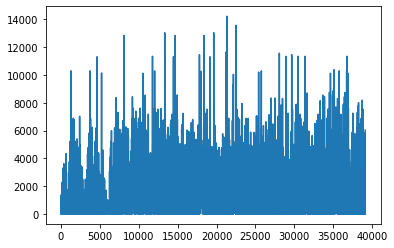

In [14]:
df_data['LIVING_SQUARE_FEET'].dropna().plot()
# pd.qcut(df['ext price'], q=4)

For sale year, sale month, property type, decade built, decile of living square feet, and whether there is a pool, I encode the values using dummy variables. 

- Create "SALE_YEAR" and "SALE_MONTH"
- BLDG_CODE: The primary building type (e.g., Bowling Alley, Supermarket).
- Create "DACADE_BUILT"

"decile of living square feet"

- "POOL": whether there is a pool

In [15]:
df_merge["SALE_YEAR"] = df_merge["SALE_DATE"]//10000
df_merge["SALE_MONTH"] = df_merge["SALE_DATE"]//100 - df_merge["SALE_YEAR"]*100
df_merge["DACADE_BUILT"] = df_merge["YEAR_BUILT"]//100

In [16]:
df_data[['SALE_YEAR', 'SALE_MONTH', 'DACADE_BUILT', 'POOL']] = df_merge[['SALE_YEAR', 'SALE_MONTH', 'DACADE_BUILT', 'POOL']]

In [17]:
dummy = ["SALE_YEAR", "SALE_MONTH", "DACADE_BUILT", "POOL"]
for col in dummy:
    df_data[col] = df_data[col].fillna(col+"-1")

In [18]:
for col in dummy:
    df_data = df_data.join(pd.get_dummies(df_data[col]))

In [19]:
df_data = df_data.drop(dummy, axis = 1)
df_data

,TOTAL_VALUE_CALCULATED,BEDROOMS,LIVING_SQUARE_FEET,GARAGE,BASEMENT_SQUARE_FEET,LAND_SQUARE_FOOTAGE,STYLE,YEAR_BUILT,BLDG_IMPV_CODE,QUALITY,...,9.0,10.0,11.0,12.0,SALE_MONTH-1,18.0,19.0,20.0,DACADE_BUILT-1,POOL-1
0,68000.0,-1.0,-1.0,-1.0,-1.0,80150.0,0,-1.0,0,0,...,0,1,0,0,0,0,0,0,1,1
4,82000.0,-1.0,-1.0,-1.0,-1.0,20038.0,0,1970.0,0,1,...,1,0,0,0,0,0,1,0,0,1
12,83300.0,-1.0,-1.0,-1.0,-1.0,21780.0,0,1997.0,0,3,...,0,0,0,0,1,0,1,0,0,1
15,204800.0,-1.0,-1.0,-1.0,-1.0,18661.0,0,1991.0,0,3,...,0,0,0,0,1,0,1,0,0,1
19,472700.0,-1.0,-1.0,-1.0,-1.0,1166101.0,0,-1.0,0,0,...,1,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39115,244700.0,3.0,1400.0,-1.0,-1.0,48787.0,1,1988.0,0,1,...,0,0,0,0,1,0,1,0,0,1
39116,221200.0,3.0,1420.0,-1.0,-1.0,10018.0,1,2009.0,0,4,...,0,0,0,0,0,0,0,1,0,1
39119,384000.0,3.0,1704.0,-1.0,-1.0,6098.0,1,1985.0,0,1,...,0,1,0,0,0,0,1,0,0,1
39120,226800.0,3.0,1260.0,-1.0,-1.0,15522.0,1,1975.0,0,1,...,0,0,0,0,0,0,1,0,0,1


In [20]:
df_data.columns

Index(['TOTAL_VALUE_CALCULATED',               'BEDROOMS',
           'LIVING_SQUARE_FEET',                 'GARAGE',
         'BASEMENT_SQUARE_FEET',    'LAND_SQUARE_FOOTAGE',
                        'STYLE',             'YEAR_BUILT',
               'BLDG_IMPV_CODE',                'QUALITY',
                         'VIEW',       'AIR_CONDITIONING',
                      'HEATING',                   'FUEL',
                        'FRAME',         'EXTERIOR_WALLS',
                        'SEWER',                  'WATER',
                    'ROOF_TYPE',                  'FLOOR',
           'LOCATION_INFLUENCE',                   1969.0,
                         1974.0,                   1986.0,
                         1990.0,                   1995.0,
                         1996.0,                   1997.0,
                         1999.0,                   2000.0,
                         2001.0,                   2002.0,
                         2003.0,                   2004.

For the remaining characteristics described above, I use embeddings.

define the embeddings to have dimensionality of half the number of unique values of a column, with a
max of 500. I also use embeddings for the Census tract in which the house is located. By using embeddings, the model can ‘discover’ that two tracts (perhaps sharing a border) are quite similar;
if the tracts are similar in their e ects on sales, they will be close in the embedding space as well
(i.e. their embedding vectors will have similar values).

In [21]:
class Corelogic_Dataset(Dataset):
    def __init__(self, labels, features):  
        self.labels = labels
        self.features = features
        self.len = len(labels)

    def __getitem__(self, index):
        label = torch.tensor(self.labels[index])
        feature = self.features[index]
        return feature, label
    
    def __len__(self):
        return self.len

dataset = Corelogic_Dataset(torch.tensor(np.array(df_data.iloc[:, 0])), torch.tensor(np.array(df_data.iloc[:, 1:])))

# Split dateset into training set and test set
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

print("train_size is", train_size)
print("test_size is", test_size)

'''
# Add validation set
valid_size = int(len(trainset) * 0.2)
train_size = len(trainset) - valid_size
trainset, validset = torch.utils.data.random_split(trainset, [train_size, valid_size], generator=torch.Generator().manual_seed(42))
'''





train_size is 16800
test_size is 7201


'\n# Add validation set\nvalid_size = int(len(trainset) * 0.2)\ntrain_size = len(trainset) - valid_size\ntrainset, validset = torch.utils.data.random_split(trainset, [train_size, valid_size], generator=torch.Generator().manual_seed(42))\n'

In [22]:
dataset.labels[0]

tensor(68000., dtype=torch.float64)

In [23]:
# Hyperparameters
batch_size = 16
epochs = 10

In [24]:
# Load datasets
train_loader = torch.utils.data.DataLoader(dataset = trainset, batch_size = batch_size, shuffle = False) # shuffle has to be False
test_loader = torch.utils.data.DataLoader(dataset = testset, batch_size = batch_size, shuffle = False) # shuffle has to be False
# valid_loader = torch.utils.data.DataLoader(dataset = validset, batch_size = batch_size, shuffle = False) # shuffle has to be False


# Model architecture from the paper

In [ ]:
![](https://drive.google.com/uc?export=view&id=XXX)

![](/content/Model architecture.jpg）

In [25]:
# DNN
class DNN(nn.Module):
    def __init__(self, input_dim, batch_first = True):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 2500)
        self.fc1_bn = nn.BatchNorm1d(2500)
        
        self.fc2 = nn.Linear(2500, 1500)
        self.fc2_bn = nn.BatchNorm1d(1500)
        
        self.fc3 = nn.Linear(1500, 500)
        self.fc3_bn = nn.BatchNorm1d(500)
        
        self.fc4 = nn.Linear(500, 100)
        self.fc4_bn = nn.BatchNorm1d(100)
        
        self.fc5 = nn.Linear(100, 1) # 50
        self.fc5_bn = nn.BatchNorm1d(1) # 50
        
        # self.dropout = nn.Dropout(0.25)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        x = self.fc1_bn(F.relu(self.fc1(x)))
        x = self.fc2_bn(F.relu(self.fc2(x)))
        x = self.fc3_bn(F.relu(self.fc3(x)))
        x = self.fc4_bn(F.relu(self.fc4(x)))
        output = self.fc5_bn(F.relu(self.fc5(x)))
        # output = self.sigmoid(x)
        
        return output

The Tax data include many characteristics of the property, including: number of bedrooms
and bathrooms; living, garage, basement, and land square footage; the style of the building, when
it was built, and whether refurbished; a measure of quality (e.g. ‘Fair’); what type of view the
property has (e.g., ‘Mountains’) and other ‘location influences’; whether the property has a pool;
the type of air conditioning, heating, fuel, framing, walls, sewage, water, roof, and floor; and the
precise location. Some of these variables are frequently missing – in all such cases, I replace the
missing values with an indicator for missing data. I also discretize continuous variables such as
living square footage into deciles.

In [26]:
num_features = df_data.shape[1] - 1
# Model Initialization
input_dim = num_features
output_dim = 1

I use an Adam optimizer with a cosine
annealing learning rate, such that the learning rates starts high and then decreases following a
half-cosine curve. https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html

In [27]:
'''
# early stopping patience; how long to wait after last time validation loss improved.
patience = 20
# initialize the early_stopping object
early_stopping = EarlyStopping(patience = patience, verbose = True)
'''


model = DNN(input_dim).to(device)
print(model)

# Parameters
learning_rate = 0.1 # Initial learning rate
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=20) # Default parameters: eta_min=0, last_epoch=-1, verbose=False
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)      

model.apply(init_weights)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

DNN(
  (fc1): Linear(in_features=67, out_features=2500, bias=True)
  (fc1_bn): BatchNorm1d(2500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2500, out_features=1500, bias=True)
  (fc2_bn): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1500, out_features=500, bias=True)
  (fc3_bn): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=500, out_features=100, bias=True)
  (fc4_bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=100, out_features=1, bias=True)
  (fc5_bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sigmoid): Sigmoid()
)
The model has 4,731,403 trainable parameters


In [28]:
output[0].shape

NameError: ignored

In [29]:
iter = 0
for epoch in range(epochs):
    for input, target in train_loader:
        optimizer.zero_grad()
        output = model(input.float()) # Add .float() to solve expected scalar type float but found Double
        loss = criterion(output, target.unsqueeze(1)) # Add .long() to solve expected scalar type Long but found Double
        loss.backward()
        optimizer.step()
        iter += 1   
        if iter % 100 == 0: 
          print('Iteration: {}, Loss: {:.5f}'.format(iter, loss.item()))
    scheduler.step()


# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Iteration: 100, Loss: -3479900.35631
Iteration: 200, Loss: -6737378.06103
Iteration: 300, Loss: -15609158.67138
Iteration: 400, Loss: -25234945.18420
Iteration: 500, Loss: -18560958.32121
Iteration: 600, Loss: -17350287.81968
Iteration: 700, Loss: -47038803.30809
Iteration: 800, Loss: -20045648.15400
Iteration: 900, Loss: -30667744.00017
Iteration: 1000, Loss: -31939404.48967
Iteration: 1100, Loss: -25180248.07381
Iteration: 1200, Loss: -37426839.31559
Iteration: 1300, Loss: -47756881.05061
Iteration: 1400, Loss: -100959241.18331
Iteration: 1500, Loss: -30334604.40928
Iteration: 1600, Loss: -46871049.27447
Iteration: 1700, Loss: -48737597.94056
Iteration: 1800, Loss: -21778398.12693
Iteration: 1900, Loss: -86940081.12433
Iteration: 2000, Loss: -106800938.18758
Iteration: 2100, Loss: -95661328.89362
Iteration: 2200, Loss: -76102239.11430
Iteration: 2300, Loss: -71169429.05367
Iteration: 2400, Loss: -113592465.14164
Iteration: 2500, Loss: -145921653.10852
Iteration: 2600, Loss: -89317688

FileNotFoundError: ignored

In [30]:
model.eval()

DNN(
  (fc1): Linear(in_features=67, out_features=2500, bias=True)
  (fc1_bn): BatchNorm1d(2500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2500, out_features=1500, bias=True)
  (fc2_bn): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1500, out_features=500, bias=True)
  (fc3_bn): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=500, out_features=100, bias=True)
  (fc4_bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=100, out_features=1, bias=True)
  (fc5_bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sigmoid): Sigmoid()
)

In [35]:
# Test
def test(dataloader, model, criterion):
    test_loss = []
    Y_valid = []
    Y_pred = []
    
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
      for input, target in dataloader:
        optimizer.zero_grad()
        output = model(input.float()) 
        test_loss += criterion(output, target.unsqueeze(1)).item()
        Y_valid.append(target)
        Y_pred.append(output)

    test_loss /= batch_size 
    # correct /= size
    return Y_valid, Y_pred, test_loss

Y_valid, Y_pred, test_loss = test(test_loader, model, criterion)

# Save model
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth") 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Saved PyTorch Model State to model.pth


In [36]:
test_loss

4084040301185933.0

In [ ]:
'''
# Train

# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = [] 

iter = 0
'''
for epoch in range(epochs):
    for input, target in train_loader:
        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    scheduler.step()







for epoch in range(epochs):
    for i, (x, y) in enumerate(train_loader):
        # print(i)
        # model.train()
        xx = x
        # print(x.shape)
        # print(x)
        x.requires_grad_().to(device)
        
        optimizer.zero_grad()
        # y = y.long().to(device) # expected scalar type Long but found Float
        y = y.to(device) # Solve result type Float can't be cast to the desired output type Long
        # print("y.shape", y.shape)
        sequence_len(y, max_encounter)
        
        # print(y.seq_len)
        outputs = model(x)
        # outputs.squeeze(-1)
        # print(outputs.shape)
        # print(outputs)
        
        output_list, target_list = num_multilabel(outputs.squeeze(-1), y)
    
        loss = criterion(output_list, target_list)
        loss.backward()
        optimizer.step()
        iter += 1   
        if iter % 100 == 0: 
            print('Iteration: {}, Loss: {:.5f}'.format(iter, loss.item()))
        # xxx = outputs
        yyy = y
        
        train_losses.append(loss.item())
        # break    
    xxx.append(outputs)
    # break
    for x, y in valid_loader:
        sequence_len(y, max_encounter)
        
        y = y.to(device)
        outputs = model(x)
        loss = criterion(outputs.squeeze(-1), y)
        # record validation loss
        valid_losses.append(loss.item())
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
        
        
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
        
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

# Test

# Calculate the Accuracy
def accuracy_multilabel(output, target):
    assert output.shape == target.shape, \
        "shapes output: {}, and target:{} are not aligned. ".\
            format(output.shape, target.shape)
    # output.sigmoid_()
    mask_num = (Y_valid == -1).sum().numpy() # We don't want to calculate target == -1
    output = output >= 0.5
    # a = torch.round(output).eq(target).sum().cpu().numpy() 
    a = output.eq(target).sum().cpu().numpy() 
    b = (target.numel()- mask_num)
    return a/b
        
    # return torch.round(output).eq(target).sum().cpu().numpy() -  mask_num / (target.numel()- mask_num)

def test(dataloader, model, criterion):
    test_loss = []
    Y_valid = []
    Y_pred = []
    # Y_score = np.empty(shape = [0, 2])
    
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            # print(y)
            # print(x.shape)

            sequence_len(y, max_encounter)
           
            y = y.to(device)
            
            # print("y.shape is", y.shape)
            outputs = model(x)
            # print(outputs)
            
            Y_valid.append(y)
            Y_pred.append(outputs.sigmoid_()) # This is the logit
            
            # print(len(Y_pred))
            # print(accuracy_multilabel(Y_valid, Y_pred))
            
            
            '''
            Y_valid = np.append(Y_valid, y.numpy())
            Y_score = np.concatenate((Y_score, logits), axis = 0)
            Y_pred = np.append(Y_pred, np.amax(outputs.numpy(), 1))
            '''      
            
            test_loss += criterion(outputs.squeeze(-1), y).item()
    
    
    # print(len(Y_pred))
    Y_pred = torch.cat(Y_pred, dim = 0)
    Y_pred = Y_pred.squeeze(-1) 
    Y_valid = torch.cat(Y_valid, dim = 0) 
    
    
    test_loss /= batch_size
    # correct /= size
    
    # return Y_valid, Y_pred, Y_score
    return Y_valid, Y_pred

# Y_valid, Y_pred, Y_score = test(test_loader, model, criterion)
Y_valid, Y_pred = test(test_loader, model, criterion)
accuracy = accuracy_multilabel(Y_pred, Y_valid)
# print(f"Test Error: \n Accuracy: {(100 * accuracy): > 0.1f}%, Avg loss: {test_loss:>8f} \n")
print(f"Test Error: \n Accuracy: {(100 * accuracy): > 0.1f}% \n")

# Save model
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth") 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


RuntimeError: ignored

# Draft

In [ ]:
list(df_merge.columns)

['FIPS_x',
 'APN_UNFORMATTED',
 'PCL_ID_IRIS_FORMATTED',
 'APN_SEQUENCE_NUMBER',
 'PENDING_RECORD_INDICATOR',
 'CORPORATE_INDICATOR',
 'OWNER_FULL_NAME',
 'OWNER_1_LAST_NAME',
 'OWNER_1_FIRST_NAME___M_I',
 'OWNER_2_LAST_NAME',
 'OWNER_2_FIRST_NAME___MI',
 'OWNER_ETAL_INDICATOR_x',
 'C_O_NAME',
 'OWNER_RELATIONSHIP_RIGHTS_CODE',
 'OWNER_RELATIONSHIP_TYPE_x',
 'PARTIAL_INTEREST_INDICATOR',
 'ABSENTEE_OWNER_STATUS_x',
 'PROPERTY_LEVEL_LATITUDE',
 'PROPERTY_LEVEL_LONGITUDE',
 'SITUS_HOUSE_NUMBER_PREFIX_x',
 'SITUS_HOUSE_NUMBER_x',
 'SITUS_HOUSE_NUMBER_SUFFIX_x',
 'SITUS_DIRECTION_x',
 'SITUS_STREET_NAME_x',
 'SITUS_MODE_x',
 'SITUS_QUADRANT_x',
 'SITUS_APARTMENT_UNIT',
 'SITUS_CITY_x',
 'SITUS_STATE_x',
 'SITUS_ZIP_CODE_x',
 'SITUS_CARRIER_CODE_x',
 'MAILING_HOUSE_NUMBER_PREFIX',
 'MAILING_HOUSE_NUMBER',
 'MAILING_HOUSE_NUMBER_SUFFIX',
 'MAILING_DIRECTION',
 'MAILING_STREET_NAME',
 'MAILING_MODE',
 'MAILING_QUADRANT',
 'MAILING_APARTMENT_UNIT',
 'MAILING_PROPERTY_CITY',
 'MAILING_PROPERTY_

In [ ]:
df_schema = pd.read_csv("Corelogic_Schema.csv")
df_schema

,Field name,Type,Mode,Policy Tags,Description,Unnamed: 5
0,FIPS_CODE,INTEGER,NULLABLE,NaN,NaN,NaN
1,UNFORMATTED_APN,STRING,NULLABLE,NaN,NaN,NaN
2,APN_SEQUENCE_NBR,INTEGER,NULLABLE,NaN,NaN,NaN
3,FORMATTED_APN,STRING,NULLABLE,NaN,NaN,NaN
4,ORIGINAL_APN,STRING,NULLABLE,NaN,NaN,NaN
...,...,...,...,...,...,...
173,UTILITIES,STRING,NULLABLE,NaN,NaN,NaN
174,WATER,STRING,NULLABLE,NaN,NaN,NaN
175,LEGAL1,STRING,NULLABLE,NaN,NaN,NaN
176,LEGAL2,STRING,NULLABLE,NaN,NaN,NaN


In [ ]:
s = ""
for i in df_schema.index:
    s = s + df_schema.iloc[i][0] + ":STRING" + ",\n"
with open('schema_tax.txt','w') as f:
   f.write(s)

In [ ]:
# Example: cast (FA_StatusChangeDate as timestamp) as FA_StatusChangeDate,
s = ""
for i in df_schema.index:
    s = s + "cast (" + df_schema.iloc[i][0] + " as " + df_schema.iloc[i][1] + ") as " + df_schema.iloc[i][0] + ",\n"
print(s)

cast (FIPS_CODE as INTEGER) as FIPS_CODE,
cast (UNFORMATTED_APN as STRING) as UNFORMATTED_APN,
cast (APN_SEQUENCE_NBR as INTEGER) as APN_SEQUENCE_NBR,
cast (FORMATTED_APN as STRING) as FORMATTED_APN,
cast (ORIGINAL_APN as STRING) as ORIGINAL_APN,
cast (PREVIOUS_PARCEL_NUMBER as STRING) as PREVIOUS_PARCEL_NUMBER,
cast (P_ID_IRIS_FRMTD as STRING) as P_ID_IRIS_FRMTD,
cast (ACCOUNT_NUMBER as STRING) as ACCOUNT_NUMBER,
cast (MAP_REFERENCE1 as STRING) as MAP_REFERENCE1,
cast (MAP_REFERENCE2 as STRING) as MAP_REFERENCE2,
cast (CENSUS_TRACT as INTEGER) as CENSUS_TRACT,
cast (BLOCK_NUMBER as STRING) as BLOCK_NUMBER,
cast (LOT_NUMBER as INTEGER) as LOT_NUMBER,
cast (RANGE as STRING) as RANGE,
cast (TOWNSHIP as STRING) as TOWNSHIP,
cast (SECTION as STRING) as SECTION,
cast (QUARTER_SECTION as STRING) as QUARTER_SECTION,
cast (FLOOD_ZONE_COMMUNITY_PANEL_ID as STRING) as FLOOD_ZONE_COMMUNITY_PANEL_ID,
cast (LAND_USE as INTEGER) as LAND_USE,
cast (COUNTY_USE1 as INTEGER) as COUNTY_USE1,
cast (COUNTY

In [ ]:
# an Embedding module containing 10 tensors of size 3
embedding = nn.Embedding(10, 3)
# a batch of 2 samples of 4 indices each
input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
embedding(input).shape

torch.Size([2, 4, 3])

In [ ]:
input.shape

torch.Size([2, 4])

In [ ]:
a = torch.LongTensor([0])
embedding = torch.nn.Embedding(2, 5)
b = embedding(a)
b

tensor([[-0.6969, -0.3368,  0.0170,  2.5383,  0.6692]],
       grad_fn=<EmbeddingBackward0>)

In [ ]:
b.shape

torch.Size([1, 5])

In [ ]:
a = torch.LongTensor([0])
embedding = torch.nn.Embedding(2, 5)
b = embedding(a)
b

tensor([[-1.9749, -0.7586,  1.4398,  0.5521, -0.9233]],
       grad_fn=<EmbeddingBackward0>)

In [ ]:
import torch.nn.functional as F
import torch

input = torch.tensor([[1,2,4,5]])
weights = torch.rand(10, 3)
F.embedding(input, weights)

tensor([[[0.0580, 0.5820, 0.9879],
         [0.8315, 0.5699, 0.0161],
         [0.4875, 0.5510, 0.1167],
         [0.8401, 0.6876, 0.5747]]])

In [ ]:
F.embedding(input, weights).shape

torch.Size([1, 4, 3])

In [ ]:
F.one_hot(torch.arange(0, 5) % 3)

tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0]])

In [ ]:
F.one_hot(torch.arange(0, 5) % 3)

tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0]])

In [ ]:
F.one_hot(df_data["QUALITY"].values)

TypeError: one_hot(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
list(df_data["STYLE"].unique())

['-1', '001', 'DES', 'MAN', 'CTB', 1.0, 'TWN', 'RAN']

In [ ]:
labels

['-1', 'QAV', 'QFA', 'QGO', 'QVV', 'QPO', 'QEX']

In [ ]:
from sklearn import preprocessing
import torch

labels = list(df_data["STYLE"].unique())
le = preprocessing.LabelEncoder()
le.fit_transform(labels)
le.transform(df_data["STYLE"])

# targets = torch.as_tensor(targets)
# targets: tensor([0, 1, 2, 3])

array([0, 0, 0, ..., 1, 1, 4])

In [ ]:
le

LabelEncoder()

In [ ]:
targets

tensor([0, 1, 3, 4, 6, 5, 2])